In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = False

In [3]:
np.eye(3)[2]

array([0., 0., 1.])

In [4]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = 'PetImages/Dog'
    LABELS = {CATS:0,DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in tqdm(self.LABELS):
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = f"{label}/{f}"
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        for _ in range(50):
            np.random.shuffle(self.training_data)
        np.save('training_data.npy',self.training_data)
        print(f'Cats : {self.catcount}')
        print(f'Dogs : {self.dogcount}')

In [5]:
if REBUILD_DATA:
        dvc = DogsVSCats()
        dvc.make_training_data()

In [6]:
training_data = np.load('training_data.npy',allow_pickle=True)

In [7]:
len(training_data)

24946

In [8]:
print(training_data[0])

[array([[44, 47, 46, ...,  5, 51, 52],
       [45, 50, 69, ...,  5, 54, 55],
       [42, 43, 48, ...,  8, 57, 54],
       ...,
       [27, 31, 98, ..., 34, 34, 34],
       [74, 93, 99, ..., 32, 32, 31],
       [84, 90, 93, ..., 30, 28, 29]], dtype=uint8)
 array([1., 0.])]


In [9]:
print(training_data[1])

[array([[ 65,  63,  61, ...,  15,  16,  14],
       [ 67,  66,  64, ...,  32, 175, 174],
       [ 73,  68,  67, ...,  31, 229, 230],
       ...,
       [ 36,  10,  17, ..., 116, 127, 129],
       [ 21,  21,  22, ...,  82, 122, 128],
       [ 19,  31,  57, ...,  19,  77, 120]], dtype=uint8)
 array([1., 0.])]


In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

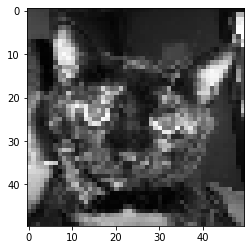

In [11]:
plt.imshow(training_data[1][0],cmap='gray')
plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        self.fc1 = nn.Linear(128 * 5 * 5,512)
        self.fc2 = nn.Linear(512,2)
    
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        print(x.shape)
        x = x.view(-1,128*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)

In [14]:
net = Net()

In [15]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [16]:
import torch.optim as optim

In [17]:
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_funtion = nn.MSELoss()

In [18]:
X = []
y = []

In [19]:
for i in training_data:
    X.append(i[0]/255.0)
    y.append(i[1])

In [20]:
X = torch.Tensor(X)
y = torch.Tensor(y)

In [21]:
len(X)

24946

In [22]:
len(y)

24946

In [23]:
X = X.view(-1,50,50) # 50,50 is the img size

In [24]:
VAl_PCT = 0.25
val_size = int(len(X)*VAl_PCT)
print(val_size)

6236


In [25]:
X_train = X[:-val_size]
y_train = y[:-val_size]
X_test = X[-val_size:]
y_test = X[-val_size:]

In [26]:
print(len(X_train))

18710


In [27]:
print(len(X_test))

6236


In [28]:
BATCH_SIZE = 100
EPCOHS = 100
for epoch in range(EPCOHS):
    for i in tqdm(range(0, len(X_train), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = X_train[i:i+BATCH_SIZE].view(-1,128*5*5)
        batch_y = y_train[i:i+BATCH_SIZE]
        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_funtion(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/188 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 3200]' is invalid for input of size 250000

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

In [163]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)


class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

BATCH_SIZE = 100
EPOCHS = 1


def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")


def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
24946


In [164]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [165]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
net = Net().to(device)

In [ ]:
EPOCHS = 100

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 32
    EPOCHS = 250
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()

            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)

Epoch: 0. Loss: 0.19646070897579193
Epoch: 1. Loss: 0.1471402645111084
Epoch: 2. Loss: 0.11289826780557632
Epoch: 3. Loss: 0.1060304194688797
Epoch: 4. Loss: 0.08537285774946213
Epoch: 5. Loss: 0.06543461978435516
Epoch: 6. Loss: 0.035588450729846954
Epoch: 7. Loss: 0.07862048596143723
Epoch: 8. Loss: 0.020282069221138954
Epoch: 9. Loss: 0.014307864010334015
Epoch: 10. Loss: 0.037449803203344345
Epoch: 11. Loss: 0.00981384888291359
Epoch: 12. Loss: 0.03204044699668884
Epoch: 13. Loss: 0.037781450897455215
Epoch: 14. Loss: 0.03460770845413208
Epoch: 15. Loss: 0.0028460314497351646
Epoch: 16. Loss: 0.040707387030124664
Epoch: 17. Loss: 0.019251180812716484
Epoch: 18. Loss: 0.02086319401860237
Epoch: 19. Loss: 0.04464838281273842
Epoch: 20. Loss: 0.00046379482955671847
Epoch: 21. Loss: 0.001634777756407857
Epoch: 22. Loss: 0.0007858287426643074
Epoch: 23. Loss: 0.00839089136570692
Epoch: 24. Loss: 0.021580969914793968
Epoch: 25. Loss: 0.001725488342344761
Epoch: 26. Loss: 0.00051761849317

In [ ]:
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round(correct/total, 3))

In [ ]:
correct = 0
total = 0
for i in tqdm(range(0, len(test_X), BATCH_SIZE)):

    batch_X = test_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
    batch_y = test_y[i:i+BATCH_SIZE].to(device)
    batch_out = net(batch_X)

    out_maxes = [torch.argmax(i) for i in batch_out]
    target_maxes = [torch.argmax(i) for i in batch_y]
    for i,j in zip(out_maxes, target_maxes):
        if i == j:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))